# Dimensionality Reduction Algorithms

In [82]:
import numpy as np
from sklearn.datasets import fetch_openml,make_swiss_roll
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA,IncrementalPCA,KernelPCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import mean_squared_error
import matplotlib as mpl
import matplotlib.pyplot as plt

PCA - on MNIST Dataset

In [31]:
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)
X = mnist["data"]
y = mnist["target"]
# plt.imshow(X[2].reshape(28,28),cmap = mpl.cm.binary)
# plt.axis('off')
# plt.show()
# X_train, X_test, y_train, y_test = train_test_split(X, y)

In [27]:
pca = PCA(n_components=0.95) # preserve 95% of the variance in data
X_reduced = pca.fit_transform(X_train)
pca.n_components_ # compressing 784 features into 154
np.sum(pca.explained_variance_ratio_)

0.950415971401358

In [28]:
pca = PCA(n_components = 154) # Training the whole dataset
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [29]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

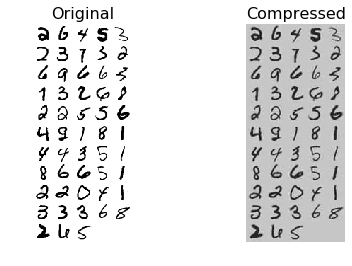

In [35]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::1000])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::1000])
plt.title("Compressed", fontsize=16)

Incremental PCA

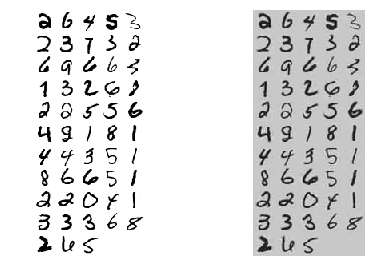

In [51]:
inc_pca = IncrementalPCA(n_components = 154)
X_batches = np.array_split(X_train,100)
# print (len(X_batches))
for i in X_batches:
    inc_pca.partial_fit(i) # fit the model on the data in each mini-batch
X_red = transformer.transform(X_train)
X_recovered_inc_pca = inc_pca.inverse_transform(X_red)
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::1000])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::1000])
plt.tight_layout()

In [56]:
# PCA and IncrementalPCA yielding identical mean values, while not perfectly identical
print (np.allclose(pca.mean_,inc_pca.mean_))
print (np.allclose(X_recovered,X_recovered_inc_pca))

True
False


Kernel PCA - on Swiss Roll Dataset

In [65]:
X,t = make_swiss_roll(n_samples=1000,noise=0.2,random_state=42)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

# lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
# rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
# sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

# y = t > 6.9

# plt.figure(figsize=(11, 4))
# for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
#     X_reduced = pca.fit_transform(X)
#     if subplot == 132:
#         X_reduced_rbf = X_reduced
    
#     plt.subplot(subplot)
#     #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
#     #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
#     plt.title(title, fontsize=14)
#     plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
#     plt.xlabel("$z_1$", fontsize=18)
#     if subplot == 131:
#         plt.ylabel("$z_2$", fontsize=18, rotation=0)
#     plt.grid(True)
# plt.show()

In [90]:
# Selecting the best set of Hyperparameters Using GridSearchCV
# *************************************************************
# **** Implementation of Pipeline followed by GridSearchCV ****
# *************************************************************
# Src: https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html#sphx-glr-auto-examples-compose-plot-compare-reduction-py

lr_pipe = Pipeline([('kpca',KernelPCA(n_components=2)),
                    ('lr',LogisticRegression(solver = 'lbfgs'))])

param_grid = [{'kpca__gamma':np.linspace(0.03,0.05,10),
               'kpca__kernel':['rbf','sigmoid','poly']}] # Note how we use double underscores to refer to the item in the pipeline
gs = GridSearchCV(lr_pipe, param_grid)
gs.fit(X,y)
print ('Best Parameters = ',gs.best_params_)
print ('Best Score = ',gs.best_score_)

C:\Users\afamili001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best Parameters =  {'kpca__gamma': 0.03, 'kpca__kernel': 'rbf'}
Best Score =  0.751


In [84]:
# Train the model with the best parameters
rbf_pca = KernelPCA(n_components=2,gamma = 0.0433,kernel='rbf',fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preconst = rbf_pca.inverse_transform(X_reduced)
print ('Squared Distance of the pre-img from the orig instance = ',mean_squared_error(X,X_preconst))

Squared Distance of the pre-img from the orig instance =  32.786308795766104


In [ ]:
# Best Hyperparameters minimizing the distance between orig img and reconstructed img

LLE

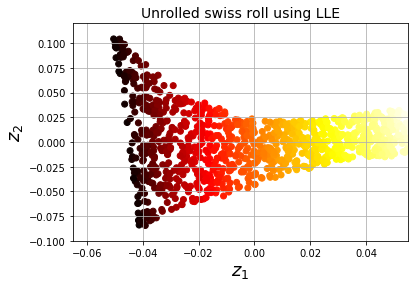

In [88]:
# AGeron
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

# Summary

In [ ]:
Dimensionality Reudction used for:
    1. Speeding up the training 
    2. Better Visualizations
    3. Does not necessarily enhance alg performance
    4. Lower chance of overfitting the training set
    
Two Main Approaches:
    ** While always speesing up the training, the approaches do not necessarily lead to a higher performance
    1. Projection
    2. Manifold Learning

Dimensionality Reduction Techniques:
    - PCA
        - Identifies the axis generating the highest variance after projection
        - Preserving the variance is key here
    - Kernel PCA 
        - Preserves clusters of instances
        - Unsupervised Learning Algorithm
    - LLE
        - Manifold Learning Technique